[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/interactive_api/numpy_linear_regression/workspace/SingleNotebook.ipynb)

# Federated Learning with BloodMNIST2D Dataset
### Dependencies and Packages
Let's get these out of the way first.

In [1]:
!python -m pip install -U pip
!python -m pip install tqdm torch torchvision medmnist matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.8/959.8 kB 7.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 6.3 MB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)


In [2]:
# To access example workspaces and director/envoy scripts
!git clone -b miccai_fl_tutorial https://github.com/intel/openfl.git
!cd openfl && python -m pip install .

fatal: destination path 'openfl' already exists and is not an empty directory.
Processing /home/karan/workspace/fl-tutorial/tutorial_notebooks/openfl
  Preparing metadata (setup.py) ... done


  Created wheel for openfl: filename=openfl-1.4-py3-none-any.whl size=615343 sha256=87a135828880aec8d08d2ce89e04505f222585d081b6b4ff61144a61c031c3b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-zup_el_5/wheels/63/88/54/cd14f60121c308a944503cb09825c66d9f4c92e44e441e9a80
Successfully built openfl
  Attempting uninstall: openfl
    Found existing installation: openfl 1.4
    Uninstalling openfl-1.4:
      Successfully uninstalled openfl-1.4


### Hacks

A few duct-tape fixes to allow us to 1-click execute.

In [3]:
import os
import logging

# Better CPU Utilization
os.environ['OMP_NUM_THREADS'] = str(int(os.cpu_count() // 2))

# Logging fix for Google Colab
log = logging.getLogger()
log.setLevel(logging.INFO)

# Switch to the workspace directory
workspace_dir = os.path.abspath(
    'openfl/openfl-tutorials/interactive_api/PyTorch_MedMNIST_2D')
os.chdir(workspace_dir)

# Part 1. Centralized Setting

Setting up your model, optimizer and data.

### Imports

In [4]:
import numpy as np
from tqdm import tqdm
from pprint import pprint

import torch
import medmnist

print('PyTorch', torch.__version__)
print('MedMNIST', medmnist.__version__)

PyTorch 1.12.1+cu102
MedMNIST 2.1.0


### Familiarize yourself with the Dataset

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label).

![Datasets in MedMNIST](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

Source: https://github.com/MedMNIST/MedMNIST

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.

### Dataset Configuration

In [5]:
# Train/test options
NUM_EPOCHS = 3
BATCH_SIZE = 64
DEVICE = 'cpu'

# Dataset
DATASET_NAME = 'bloodmnist'
DATASET_PATH = './data'
ds_info = medmnist.INFO[DATASET_NAME]
pprint(ds_info)

{'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'description': 'The BloodMNIST is based on a dataset of individual normal '
                'cells, captured from individuals without infection, '
                'hematologic or oncologic disease and free of any '
                'pharmacologic treatment at the moment of blood collection. It '
                'contains a total of 17,092 images and is organized into 8 '
                'classes. We split the source dataset with a ratio of 7:1:2 '
                'into training, validation and test set. The source images '
                'with resolution 3×360×363 pixels are center-cropped into '
                '3×200×200, and then resized into 3×28×28.',
 'label': {'0': 'basophil',
           '1': 'eosinophil',
           '2': 'erythroblast',
           '3': 'immature granulocytes(myelocytes, metamyelocytes and '
                'promyelocytes)',
           '4': 'lymphocyte',
           '5': 'monocyte',
           '6': 'neutrophil',
      

### Familiarize with the Dataset

Let's use some plotting tools here.

  0%|          | 0/35461855 [00:00<?, ?it/s]

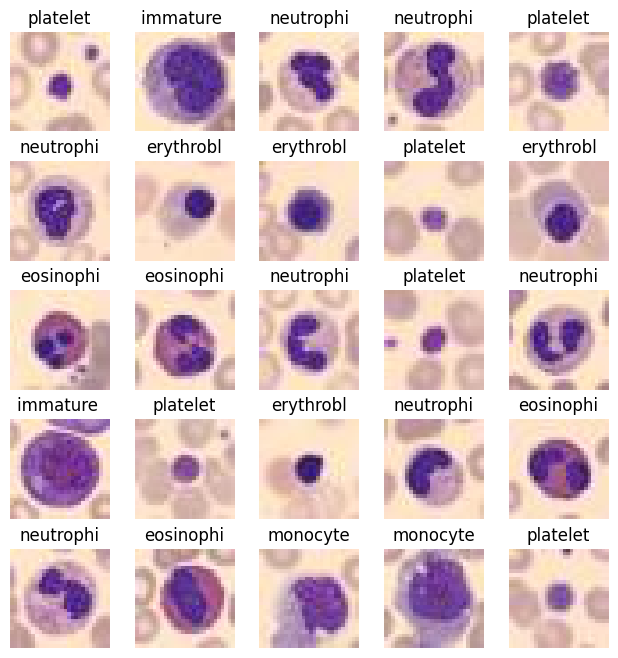

In [6]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

from envoy.medmnist_shard_descriptor import MedMNISTShardDescriptor

# Download raw numpy dataset
sd = MedMNISTShardDescriptor(datapath=DATASET_PATH, dataname=DATASET_NAME)
(x_train, y_train), (x_test, y_test) = sd.load_data()

# Visualize few samples
n_img = 5
train_samples = x_train[:n_img*n_img]

label2str = list(ds_info['label'].values())

fig, ax = plt.subplots(n_img, n_img, figsize=(8, 8))

for k in range(len(train_samples)):
    i = k // n_img
    j = k % n_img
    img = train_samples[k]
    label = np.squeeze(y_train[k])
    ax[i, j].imshow(Image.fromarray(img))
    ax[i, j].title.set_text(label2str[label][:9])
    ax[i, j].axis('off')
fig.subplots_adjust(wspace=0.03, hspace=0.3)


### Define Dataset/Dataloader Classes

We'll create a simple PyTorch-style iterator dataset that returns single `numpy` element as a `torch.Tensor`. The class used for this would be `torch.utils.data.Dataset`

We will then wrap this dataset object with a Dataloader class, that batches and shuffles the elements. Class: `torch.utils.data.DataLoader`

In [7]:

class MedMNISTDataset(Dataset):
    """MedMNIST dataset class"""

    def __init__(self, x, y, data_type: str = 'train') -> None:
        """Initialize MedMNISTDataset."""
        self.x, self.y = x, y
        self.data_type = data_type

    def __getitem__(self, index: int):
        """Return an item by the index."""
        return self.x[index], self.y[index]

    def __len__(self) -> int:
        """Return the len of the dataset."""
        return len(self.x)


class TransformedDataset(Dataset):
    """Apply transforms to each element of dataset"""

    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.target_transform:
            label = self.target_transform(label)
        else:
            label = label.astype(int)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            base_transform = T.PILToTensor()
            img = Image.fromarray(img)
            img = base_transform(img)

        return img, label


transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.], std=[1.0])])

train_ds = TransformedDataset(MedMNISTDataset(x=x_train, y=y_train),
                              transform=transform)
train_dl = DataLoader(train_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=8)

test_ds = TransformedDataset(MedMNISTDataset(x=x_test, y=y_test),
                             transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=8)


### Model Definition (CNN)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(16, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(16, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 128), 
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


test_model = Net(in_channels=ds_info['n_channels'],
                 num_classes=len(ds_info['label']))
print(test_model)
print('Total Parameters:',
      sum([torch.numel(p) for p in test_model.parameters()]))
print('Trainable Parameters:',
      sum([torch.numel(p) for p in test_model.parameters() if p.requires_grad]))


Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

### Define Training/Validation Loops

In [9]:
def train(model, train_loader, optimizer, device, criterion, task):
    model.train()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    for inputs, targets in tqdm(train_loader, desc="train"):

        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
        else:
            targets = torch.squeeze(targets, 1).long().to(device)
            loss = criterion(outputs, targets)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    total += targets.shape[0]
    correct += torch.sum(outputs.max(1)[1] == targets).item()

    return {
        'train_acc': np.round(correct / total, 3),
        'train_loss': np.round(np.mean(losses), 3),
    }


def validate(model, val_loader, device, criterion, task):
    model.eval()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="validate"):
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                m = nn.Sigmoid()
                outputs = m(outputs).to(device)
            else:
                targets = torch.squeeze(targets, 1).long().to(device)
                loss = criterion(outputs, targets)

            losses.append(loss.item())
            total += targets.shape[0]
            correct += (outputs.max(1)[1] == targets).sum().cpu().numpy()

        return {
            'val_acc': np.round(correct / total, 3),
            'val_loss': np.round(np.mean(losses), 3),
        }


### Train

This is how you'd train **with** access to all data.

In [10]:
centralized_model = Net(in_channels=ds_info['n_channels'],
                        num_classes=len(ds_info['label']))
optimizer = torch.optim.Adam(centralized_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Start!
history = validate(centralized_model,
                   test_dl,
                   device=DEVICE,
                   criterion=criterion,
                   task=ds_info['task'])
print('Before training: ', history)

for epoch in range(NUM_EPOCHS):
    train_history = train(centralized_model,
                          train_dl,
                          device=DEVICE,
                          optimizer=optimizer,
                          criterion=criterion,
                          task=ds_info['task'])
    val_history = validate(centralized_model,
                           test_dl,
                           device=DEVICE,
                           criterion=criterion,
                           task=ds_info['task'])
    print(f'Epoch {epoch}: {train_history} - {val_history}')


validate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 39.87it/s]


Before training:  {'val_acc': 0.071, 'val_loss': 2.089}


validate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 34.28it/s]


Epoch 0: {'train_acc': 0.8, 'train_loss': 0.993} - {'val_acc': 0.8, 'val_loss': 0.536}


validate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 34.93it/s]


Epoch 1: {'train_acc': 0.909, 'train_loss': 0.526} - {'val_acc': 0.856, 'val_loss': 0.409}


validate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 37.42it/s]

Epoch 2: {'train_acc': 0.818, 'train_loss': 0.414} - {'val_acc': 0.887, 'val_loss': 0.336}


# Part 2. Go Federated

### Imports

In [11]:
import os
import yaml
from pathlib import Path
from typing import Dict, List, Union

### Configure `Director`

This is the entity that orchestrates the tasks and aggregation of models from participants. Below cells are to configure the `yaml` and start the `Director` service.

In [12]:
# Should be the same as defined in `director_config.yaml`
director_node_fqdn = 'localhost'
director_port = 50051

In [13]:
cwd = Path.cwd()
director_workspace_path = Path('./director/').absolute()
print(director_workspace_path)
director_config_file = director_workspace_path / 'director_config.yaml'
director_logfile = director_workspace_path / 'director.log'
if director_logfile.is_file():
    director_logfile.unlink()

# Make these envvars visible to other shells
os.environ['main_folder'] = str(cwd)
os.environ['director_workspace_path'] = str(director_workspace_path)
os.environ['director_logfile'] = str(director_logfile)
os.environ['director_config_file'] = str(director_config_file)

/home/karan/workspace/fl-tutorial/tutorial_notebooks/openfl/openfl-tutorials/interactive_api/PyTorch_MedMNIST_2D/director


In [14]:
%%bash --bg
cd $director_workspace_path
fx director start --disable-tls -c $director_config_file > $director_logfile &
cd $main_folder

### Configure `Envoys`

`Envoy`, for sake of simplicity, can be thought of as collaborators. Technically, `Envoy` defines the dataloading interface for each participant and runs python code (called a `task`) that it receives via this notebook.

We create as many config files as number of participants that we intend to simulate here.

In [15]:
# Read the original envoy config file content
with open(Path('./envoy/envoy_config.yaml'), 'r') as f:
    orig_config = yaml.safe_load(f)


def generate_envoy_configs(
        config: Dict,
        n_cols: int,
        datapath: str,
        dataname: str,
        save_path: Union[str, Path] = './envoy/') -> List[Path]:
    config['shard_descriptor']['params']['datapath'] = datapath
    config['shard_descriptor']['params']['dataname'] = dataname
    config_paths = [(Path(save_path) / f'envoy_config_{i}.yaml').absolute()
                    for i in range(1, n_cols + 1)]

    for i, path in enumerate(config_paths):
        config['shard_descriptor']['params'][
            'rank_worldsize'] = f'{i+1},{n_cols}'
        with open(path, 'w') as f:
            yaml.safe_dump(config, f)

    return config_paths

# Cleanup. This will be required later.
def remove_configs(config_paths):
    for path in config_paths:
        path.unlink()


In [16]:
config_paths = generate_envoy_configs(orig_config,
                                      n_cols=3,
                                      datapath=DATASET_PATH,
                                      dataname=DATASET_NAME)

### Start `Envoy` processes in a loop

In [17]:
import time

def start_envoys(config_paths: List[Path]) -> None:
    for i, path in enumerate(config_paths):
        os.system(f'fx envoy start -n env_{i + 1} --disable-tls '
                  f'--envoy-config-path {path} -dh {director_node_fqdn} -dp {director_port} '
                  f'>env_{i + 1}.log &')


envoy_workspace_path = Path('./envoy/').absolute()
os.chdir(envoy_workspace_path)
start_envoys(config_paths)
time.sleep(100)

# Revert to original path
os.chdir(workspace_dir)

 97%|█████████▋| 34439168/35461855 [01:32<00:02, 393005.40it/s]

### Connect this Notebook

This is where you take the seat of a Data Scientist, who bears control over the `model`, `train()`, `validate()` and other logic that `Director` and `Envoy` help you execute across participants.

In [18]:
# Create a federation
from openfl.interface.interactive_api.federation import Federation

# Federation can also determine local fqdn automatically
federation = Federation(client_id='frontend',
                        director_node_fqdn=director_node_fqdn,
                        director_port=director_port,
                        tls=False)

# Data scientist may request a list of connected envoys
shard_registry = federation.get_shard_registry()
pprint(shard_registry)

 98%|█████████▊| 34897920/35461855 [01:32<00:01, 391833.11it/s]

{}


### Ingredients of a Federated Learning Experiment in OpenFL

* `DataInterface`: This class defines the dataloading primitives for OpenFL. We'll reuse some of our previous logic.
* `ModelInterface`: Registers model graph and optimizer; serializes them and sends them to collaborator nodes.
* `TaskInterface`: Registers the python methods that constitute each task like `training`, `validation` etc.

### `DataInterface`

In [19]:
from openfl.interface.interactive_api.experiment import DataInterface


class MedMnistFedDataset(DataInterface):

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    @property
    def shard_descriptor(self):
        return self._shard_descriptor

    @shard_descriptor.setter
    def shard_descriptor(self, shard_descriptor):
        """
        Describe per-collaborator procedures or sharding.

        This method will be called during a collaborator initialization.
        Local shard_descriptor  will be set by Envoy.
        """
        self._shard_descriptor = shard_descriptor

        self.train_set = TransformedDataset(
            self._shard_descriptor.get_dataset('train'), transform=transform)

        self.valid_set = TransformedDataset(
            self._shard_descriptor.get_dataset('val'), transform=transform)

    def get_train_loader(self, **kwargs):
        """
        Output of this method will be provided to tasks with optimizer in contract
        """
        return DataLoader(self.train_set,
                          num_workers=8,
                          batch_size=self.kwargs['train_bs'],
                          shuffle=True)

    def get_valid_loader(self, **kwargs):
        """
        Output of this method will be provided to tasks without optimizer in contract
        """
        return DataLoader(self.valid_set,
                          num_workers=8,
                          batch_size=self.kwargs['valid_bs'])

    def get_train_data_size(self):
        """
        Information for aggregation
        """
        return len(self.train_set)

    def get_valid_data_size(self):
        """
        Information for aggregation
        """
        return len(self.valid_set)


 99%|█████████▊| 34963456/35461855 [01:32<00:01, 391945.38it/s]

In [20]:
fed_dataset = MedMnistFedDataset(train_bs=BATCH_SIZE, valid_bs=BATCH_SIZE)

### `ModelInterface`

In [21]:
from openfl.interface.interactive_api.experiment import ModelInterface

model = Net(in_channels=ds_info['n_channels'],
            num_classes=len(ds_info['label']))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
framework_adapter = 'openfl.plugins.frameworks_adapters.pytorch_adapter.FrameworkAdapterPlugin'

MI = ModelInterface(model=model,
                    optimizer=optimizer,
                    framework_plugin=framework_adapter)

### `TaskInterface`
We register our tasks with a `TaskInterface` class.
OpenFL decides which model is the best based on an *increasing* metric.

In [22]:
from openfl.interface.interactive_api.experiment import TaskInterface

# Task interface currently supports only standalone functions.
TI = TaskInterface()
fixed = {'criterion': criterion, 'task': ds_info['task']}

# Train task
TI.add_kwargs(**fixed)(TI.register_fl_task(model='model',
                                           data_loader='train_loader',
                                           device='device',
                                           optimizer='optimizer')(train))

# Validate task
TI.add_kwargs(**fixed)(TI.register_fl_task(model='model',
                                           device='device',
                                           data_loader='val_loader')(validate))


<function __main__.validate(model, val_loader, device, criterion, task)>

### Run the experiment

In [23]:
from openfl.interface.interactive_api.experiment import FLExperiment

fl_experiment = FLExperiment(federation=federation,
                             experiment_name='bloodmnist2d_experiment')
fl_experiment.start(model_provider=MI,
                    task_keeper=TI,
                    data_loader=fed_dataset,
                    rounds_to_train=3,
                    device_assignment_policy='CUDA_PREFERRED')

 98%|█████████▊| 34635776/35461855 [01:32<00:02, 392998.45it/s]

[14:18:15] INFO     Building 🡆 Object CloudpickleSerializer from openfl.plugins.interface_serializer.cloudpickle_serializer Module.                  ]8;id=989847;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=78559;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           INFO     Building 🡆 Object FrameworkAdapterPlugin from openfl.plugins.frameworks_adapters.pytorch_adapter Module.                         ]8;id=146163;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=552571;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

/home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
 99%|█████████▉| 35094528/35461855 [01:33<00:01, 304373.31it/s]

           INFO     Starting experiment!                                                                                                       ]8;id=637021;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=422483;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#232\232]8;;\

           INFO     FL-Plan hash is e1d5a86e62cf1be070fbd584cf7a66279272ddb1ff6d3ee7cb5d12ee179ae6d5d253fd067652870a9d77864ee2725b1f                 ]8;id=878999;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=678092;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py#237\237]8;;\

           INFO     FL-Plan hash is e1d5a86e62cf1be070fbd584cf7a66279272ddb1ff6d3ee7cb5d12ee179ae6d5d253fd067652870a9d77864ee2725b1f                 ]8;id=40013;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=644323;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py#237\237]8;;\

           INFO     Building 🡆 Object CoreTaskRunner from openfl.federated.task.task_runner Module.                                                  ]8;id=453893;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=541450;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           INFO     Building 🡆 Object FrameworkAdapterPlugin from openfl.plugins.frameworks_adapters.pytorch_adapter Module.                         ]8;id=111770;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=803114;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

 98%|█████████▊| 34832384/35461855 [01:33<00:01, 392822.68it/s]

           WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=890402;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/utilities/utils.py\utils.py]8;;\:]8;id=764565;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/utilities/utils.py#170\170]8;;\

           WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=412312;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/utilities/utils.py\utils.py]8;;\:]8;id=622379;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/utilities/utils.py#170\170]8;;\

           INFO     SetNewExperiment                                                                                                      ]8;id=303890;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/transport/grpc/director_client.py\director_client.py]8;;\:]8;id=6896;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/transport/grpc/director_client.py#202\202]8;;\

           INFO     Experiment was accepted and launched.                                                                                      ]8;id=652760;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=464363;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#246\246]8;;\

In [24]:
# This method not only prints messages recieved from the director,
# but also saves logs in the tensorboard format (by default)
fl_experiment.stream_metrics()

100%|██████████| 35461855/35461855 [01:34<00:00, 373520.79it/s]
/home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/plugins/frameworks_adapters/pytorch_adapter.py:47: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  new_state[k] = pt.from_numpy(tensor_dict.pop(k)).to(device)
validate: 100%|██████████| 18/18 [00:00<00:00, 33.54it/s]

[14:18:23] METRIC   Round 0, collaborator trained train result train_acc:   0.444000                                                           ]8;id=517747;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=68144;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator trained train result train_loss:  1.525000                                                           ]8;id=918957;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=461840;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\


validate: 100%|██████████| 18/18 [00:00<00:00, 33.92it/s]

[14:18:24] METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_acc:       0.657000                           ]8;id=236806;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=585391;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_loss:      1.127000                           ]8;id=603890;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=333322;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_acc:    0.070000                                   ]8;id=698046;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=776060;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_loss:   2.081000                                   ]8;id=438914;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=366216;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[14:18:25] METRIC   Round 0, collaborator Aggregator train result train_acc:        0.444000                                                   ]8;id=408172;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=244991;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator train result train_loss:       1.525000                                                   ]8;id=820855;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=371952;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.657000                                   ]8;id=48508;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=401945;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator locally_tuned_model_validate result val_loss:  1.127000                                   ]8;id=430662;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=951977;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator aggregated_model_validate result val_acc:      0.070000                                   ]8;id=973632;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=56949;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\


train:   5%|▍         | 3/63 [00:00<00:06,  9.06it/s]

[14:18:26] METRIC   Round 0, collaborator Aggregator aggregated_model_validate result val_loss:     2.081000                                   ]8;id=417272;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=335686;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validate:   6%|▌         | 1/18 [00:00<00:03,  5.28it/s]

[14:18:30] METRIC   Round 1, collaborator trained train result train_acc:   0.722000                                                           ]8;id=295887;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=140284;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator trained train result train_loss:  0.947000                                                           ]8;id=576929;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=374499;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validate: 100%|██████████| 18/18 [00:00<00:00, 30.44it/s]

[14:18:31] METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_acc:       0.771000                           ]8;id=47255;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=137409;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_loss:      0.691000                           ]8;id=906056;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=208946;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_acc:    0.657000                                   ]8;id=689284;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=274296;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_loss:   1.127000                                   ]8;id=127021;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=763238;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\


train:   0%|          | 0/63 [00:00<?, ?it/s]

[14:18:33] METRIC   Round 1, collaborator Aggregator train result train_acc:        0.722000                                                   ]8;id=856200;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=930822;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator train result train_loss:       0.947000                                                   ]8;id=93996;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=963827;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.771000                                   ]8;id=731395;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=855771;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.691000                                   ]8;id=84068;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=372586;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator aggregated_model_validate result val_acc:      0.657000                                   ]8;id=242770;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=58855;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator aggregated_model_validate result val_loss:     1.127000                                   ]8;id=89917;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=901413;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

validate: 100%|██████████| 18/18 [00:00<00:00, 37.48it/s]

[14:18:38] METRIC   Round 2, collaborator trained train result train_acc:   0.889000                                                           ]8;id=392791;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=950466;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator trained train result train_loss:  0.676000                                                           ]8;id=823671;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=119197;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_acc:       0.801000                           ]8;id=82506;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=763895;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_loss:      0.535000                           ]8;id=954207;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=565554;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\


validate: 100%|██████████| 18/18 [00:00<00:00, 30.78it/s]

[14:18:39] METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_acc:    0.771000                                   ]8;id=388539;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=843355;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_loss:   0.691000                                   ]8;id=139963;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=897288;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[14:18:40] METRIC   Round 2, collaborator Aggregator train result train_acc:        0.889000                                                   ]8;id=634647;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=255057;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator train result train_loss:       0.676000                                                   ]8;id=889477;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=595837;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[14:18:41] METRIC   Round 2, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.801000                                   ]8;id=1732;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=178767;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.535000                                   ]8;id=166185;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=531226;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator aggregated_model_validate result val_acc:      0.771000                                   ]8;id=84838;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=636037;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator aggregated_model_validate result val_loss:     0.691000                                   ]8;id=728530;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=925760;file:///home/karan/workspace/fl-tutorial/miccai/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

### Cleanup

In [25]:
# To stop all services run
!pkill fx
remove_configs(config_paths)